# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# First step: Prepare the data

In this notebook we will take a look all three datasets with some data wrangling and understand their data through explore it and some useful visualizations. Finally will combine the most useful data of them and prepare it for the next step in the second notebook, build the best possible ML model.


- [Inspect datasets](#Inspect-datasets)
- [Clean and Feature engineering](#Clean-and-Feature-engineering)
- [Exploratory Data Analisys (EDA)](#Exploratory-Data-Analisy-(EDA))
- [Combine datasets](#Combine-datasets)

 

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import seaborn as sns
import time
import progressbar
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Inspect datasets

Basic inspetion about the three datasets: Portfolio, Profile and Transcript

### Portfolio Dataset

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


### Profile Dataset

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.shape

(17000, 5)

In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


### Transcript Dataset

In [9]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [10]:
transcript.shape

(306534, 4)

In [11]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## Clean and Feature engineering

### Profile dataset

In [12]:
# Rename id column to customer_id (unification with person column in Transcript dataset)
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [13]:
# check nulls sum
profile.isnull().sum()

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
dtype: int64

In [14]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99], dtype=int64)

We can see the first important issue when exists an 118 age value. Let's go to take a look about it.

In [15]:
profile[profile.age==118].count()

gender                 0
age                 2175
customer_id         2175
became_member_on    2175
income                 0
dtype: int64

In [16]:
null_rows = profile[(profile['age']==118) & (profile['gender'].isnull() & profile['income'].isnull())].count()
null_rows

gender                 0
age                 2175
customer_id         2175
became_member_on    2175
income                 0
dtype: int64

We have found a pattern here. When age is 118, customer_id and became_member_on values are nulls. So the best way to deal with this issue is drop these 2175 affected rows.

In [17]:
# profile: drop rows with no gender, income, age data
profile = profile.drop(profile[profile['gender'].isnull()].index)

In [18]:
# Parse to datetime became_member_on column
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str).astype('datetime64[ns]'))

In [19]:
# Extract year, month and day from became_member_on 
profile['year'] = profile['became_member_on'].dt.year
profile['month'] = profile['became_member_on'].dt.month
profile['day'] = profile['became_member_on'].dt.day
profile.drop(['became_member_on'], axis=1, inplace = True)

In order to prepare the dataset for modeling, a engineering feature task is to do one hot-encoding for gender categorical feature.

In [20]:
profile = pd.concat([profile, pd.get_dummies(profile['gender'], prefix='gender')], axis=1)

In [21]:
profile.head()

,gender,age,customer_id,income,year,month,day,gender_F,gender_M,gender_O
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,0,1,0


In [22]:
profile.shape

(14825, 10)

### Portfolio dataset

Exactly the same for channels column in portfolio dataset and offer_type below.

In [23]:
portfolio=portfolio.join(portfolio['channels'].str.join('|').str.get_dummies().add_prefix('channel_'))
portfolio.drop('channels', axis= 1, inplace = True)

In [24]:
# Rename id column to offer_id
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [25]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [26]:
# One-hot encoding offer_type categorical column
portfolio_cl = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])], axis=1)
portfolio_cl.drop(['offer_type'], axis=1, inplace = True)
portfolio_cl

,reward,difficulty,duration,offer_id,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [27]:
portfolio_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reward          10 non-null     int64 
 1   difficulty      10 non-null     int64 
 2   duration        10 non-null     int64 
 3   offer_id        10 non-null     object
 4   channel_email   10 non-null     int64 
 5   channel_mobile  10 non-null     int64 
 6   channel_social  10 non-null     int64 
 7   channel_web     10 non-null     int64 
 8   bogo            10 non-null     uint8 
 9   discount        10 non-null     uint8 
 10  informational   10 non-null     uint8 
dtypes: int64(7), object(1), uint8(3)
memory usage: 798.0+ bytes


In [28]:
# Save the oortfolio cleaned dataset
portfolio_cl.to_csv('data/portfolio_cleaned.csv', index = False)

### Transcript dataset

In [29]:
# Rename person column to customer_id (identical than portfolio dataset to make the join later)
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [30]:
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [31]:
len(transcript.customer_id.unique())

17000

In [32]:
len(profile.customer_id.unique())

14825

In [33]:
# Check than every customer has done different transactions (normal behaviour in any kind of bussines)
len(transcript.customer_id.unique()) == len(profile.customer_id.unique())

False

In [34]:
# Check stats for time feature (hours)
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [35]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

A tricky issue exists in value column for transcript dataset. Id offer value are referenced by 'offer id' and 'offer_id' keys in the dictionary. We need a function to extract the value regardless the two different keys.

In [36]:
# transcript: create separate columns for amount and offer_id from value col.
def create_offer_id_col(value_column):
    '''
    INPUT 
        value_column - transcript.value column dictionary
        
    OUTPUT
        Return value_column dictionary values in offer_column_names list keys
    '''
    offer_column_names = ['offer id', 'offer_id']
    
    if list(value_column.keys())[0] in offer_column_names:
        return list(value_column.values())[0]

In [37]:
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)

In [38]:
transcript['amount'] = [d.get('amount') for d in transcript.value]

In [39]:
# change amount column type to float
transcript.amount.astype('float')

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
306529    1.59
306530    9.53
306531    3.61
306532    3.53
306533    4.05
Name: amount, Length: 306534, dtype: float64

In [40]:
transcript.drop(['value'], axis= 1, inplace=True)

In [41]:
transcript.head()

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [42]:
# change amount column type to float
transcript.time.astype('float')

# Parse time column: hours to days
transcript['time_in_days'] = (transcript['time'] / 24.0)
transcript.drop(['time'], axis=1, inplace=True)

In [43]:
# transcript: drop transaction rows whose customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [44]:
len(transcript.customer_id.unique())

14825

In [45]:
# Check two datasets have the same rows
len(transcript.customer_id.unique()) == len(profile.customer_id.unique())

True

In [46]:
# Extract transcript dataset rows when they are offer xxxxx in event column
offer_tr = transcript[transcript.event != 'transaction'].copy()
offer_tr.drop(['amount'], axis=1, inplace=True)

In [47]:
# Check the value count for the different types of offers
transcript['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [48]:
offer_tr.head()

,customer_id,event,offer_id,time_in_days
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0.0
5,389bc3fa690240e798340f5a15918d5c,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0.0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,3f207df678b143eea3cee63160fa8bed,0.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0


In [49]:
# One-hot encoding for event categorical feature 
offer_tr_cl = pd.concat([offer_tr, pd.get_dummies(offer_tr.event)], axis=1)

# Drop event column
offer_tr_cl.drop(['event'], axis=1, inplace=True)

# Show offer_tr_cl dataset
offer_tr_cl.head()

,customer_id,offer_id,time_in_days,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0


In [50]:
# Check every customer have an offer related
offer_tr['customer_id'].count() == offer_tr['offer_id'].count()

True

In [51]:
offer_tr_cl.shape

(148805, 6)

In [52]:
offer_tr_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 306527
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      148805 non-null  object 
 1   offer_id         148805 non-null  object 
 2   time_in_days     148805 non-null  float64
 3   offer completed  148805 non-null  uint8  
 4   offer received   148805 non-null  uint8  
 5   offer viewed     148805 non-null  uint8  
dtypes: float64(1), object(2), uint8(3)
memory usage: 5.0+ MB


In [53]:
# Extract transcript rows when event is a transaction
transaction_tr = transcript[transcript.event == 'transaction'].copy()

# Then drop offer_id column (this column belongs to event = offer xxxxx)
transaction_tr.drop(['offer_id'], axis=1, inplace=True)

In [54]:
# Shor transaction_tr dataset
transaction_tr.head()

,customer_id,event,amount,time_in_days
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0.83,0.0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0.0
12659,54890f68699049c2a04d415abc25e717,transaction,13.23,0.0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51,0.0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97,0.0


## Exploratory Data Analisys (EDA)  

After make some task of feature engineering and data wrangling in the three datasets, now we go to explore the data, show some visualizations, check for outliers and find for correlations.

### Profile Dataset

In [55]:
# Show profile dataset 
profile.head()

,gender,age,customer_id,income,year,month,day,gender_F,gender_M,gender_O
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,0,1,0
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,0,1,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,0,1,0


In [56]:
# Check for age stats feature
profile['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

It is important to discretize features like age in order to segment by intervals different customer ages to show some interesting visualizations.

In [57]:
# Discretize age feature (segment and sort)
profile['age_separation']=pd.cut(x=profile['age'], bins=[0,10,20,30,40,50,60,70,80,90,100,110])

# Concat the new columns to profile dataset
profile = pd.concat([profile, pd.get_dummies(profile['age_separation'], prefix='age')], axis=1)

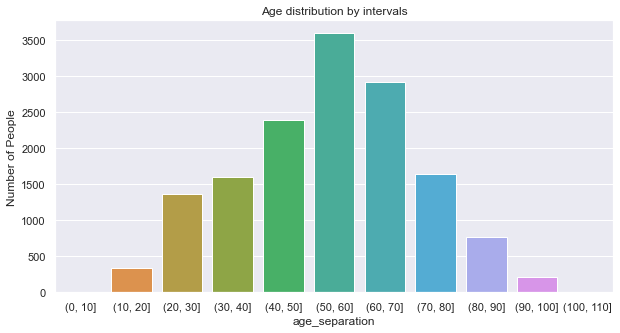

In [58]:
# Show age distribution
ax = plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
ax = sns.countplot(x='age_separation', data=profile).set_title('Age distribution by intervals')
ax = plt.ylabel('Number of People')

As you can see, 50-60 interval age is the most frequent in the age distribution of Starbucks members. Mean age is exactly 54,39 years old.

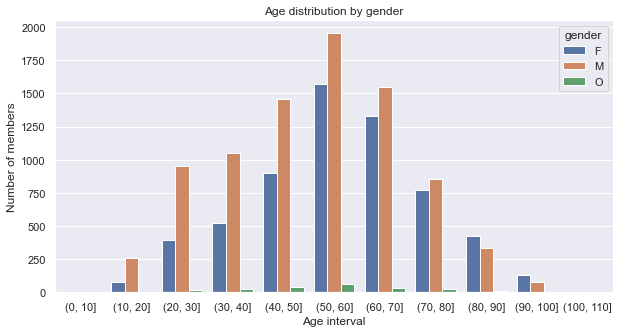

In [59]:
# groupby age and gender
membership_age = profile.groupby(['age_separation', 'gender']).size()
membership_age = membership_age.reset_index()
membership_age.columns = ['age_separation', 'gender', 'count']

# plot a barplot for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='age_separation', y='count', hue='gender', data=membership_age).set_title('Age distribution by gender')
plt.xlabel('Age interval')
plt.ylabel('Number of members');

In [60]:
# Value count for genders
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

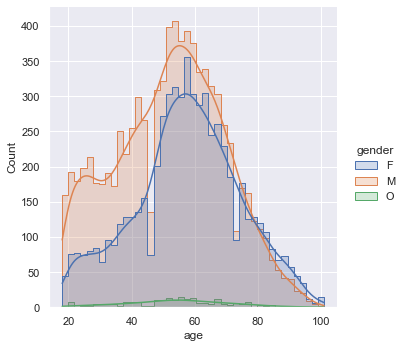

In [61]:
# Show age by gender displot distributions
sns.displot(profile, x="age", hue="gender", element="step", kde = True)

Normally, male gender is most frequent for all ages, overall from 0 to 70 but female are most at 80 years age. This is surely  because of the best life expectancy than men.

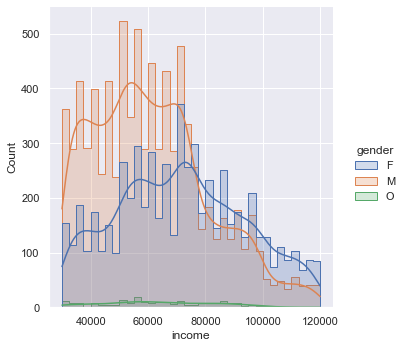

In [62]:
# Show income by gender displot distributions
sns.displot(profile, x="income", hue="gender", element="step", kde = True)

Income distribution between genders show us that exists most of men in 40k-75k stripe aproxymately but are most of women from 75k to 120k in $ per year. 

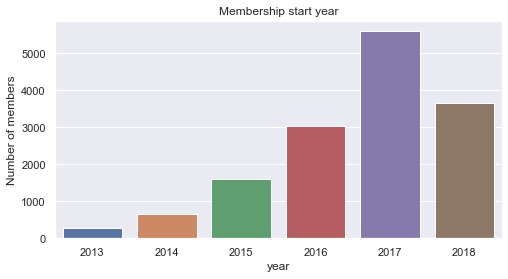

In [63]:
ax = plt.figure(figsize=(8,4))
sns.set(font_scale = 1)
ax = sns.countplot(x="year", data=profile).set_title('Membership start year')
ax = plt.ylabel('Number of members')

The most success year in join Starbucks members was 2017.

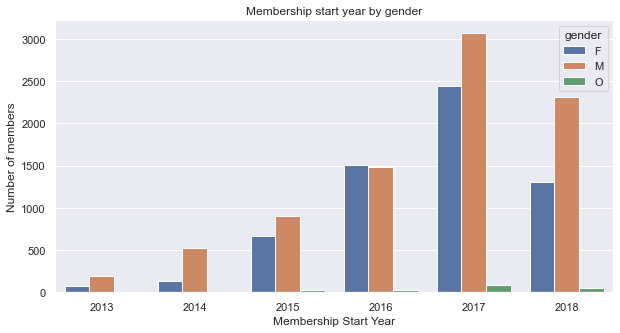

In [64]:
# groupby year and gender
membership_date = profile.groupby(['year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['year', 'gender', 'count']

# show the year became member distribution visualization by gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='count', hue='gender', data=membership_date).set_title('Membership start year by gender')
plt.xlabel('Membership Start Year')
plt.ylabel('Number of members');

In [65]:
# Drop gender and age_separation columns
profile.drop(['gender'], axis = 1, inplace = True)
profile.drop(['age_separation'], axis = 1, inplace = True)

In [66]:
# Show profile dataset
profile.head()

,age,customer_id,income,year,month,day,gender_F,gender_M,gender_O,"age_(0, 10]","age_(10, 20]","age_(20, 30]","age_(30, 40]","age_(40, 50]","age_(50, 60]","age_(60, 70]","age_(70, 80]","age_(80, 90]","age_(90, 100]","age_(100, 110]"
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,0,0,0,0,0,0,0,0,0,1,0,0,0
5,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,26,0,1,0,0,0,0,0,0,0,1,0,0,0,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,9,0,1,0,0,0,0,0,0,0,1,0,0,0,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,11,0,1,0,0,0,0,0,0,1,0,0,0,0,0


### Transcript data

In [67]:
# Show offer_tr_cl dataset
offer_tr_cl.head()

,customer_id,offer_id,time_in_days,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0


In [68]:
offer_tr_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 306527
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      148805 non-null  object 
 1   offer_id         148805 non-null  object 
 2   time_in_days     148805 non-null  float64
 3   offer completed  148805 non-null  uint8  
 4   offer received   148805 non-null  uint8  
 5   offer viewed     148805 non-null  uint8  
dtypes: float64(1), object(2), uint8(3)
memory usage: 5.0+ MB


In [69]:
# Check for profile and offer_tr_cl shapes 
print(profile.shape)
print(offer_tr_cl.shape)

(14825, 20)
(148805, 6)


This is a key point, we need to merge the two datasets on customer_id column in order to get the most important data of offers and profile dataset.

In [70]:
# Merge profile and offer_tr_cl on customer_id column
offer_profile = pd.merge(profile, offer_tr_cl, on='customer_id', how='inner')

In [71]:
# Show the merged dataset
offer_profile.head()

,age,customer_id,income,year,month,day,gender_F,gender_M,gender_O,"age_(0, 10]",...,"age_(60, 70]","age_(70, 80]","age_(80, 90]","age_(90, 100]","age_(100, 110]",offer_id,time_in_days,offer completed,offer received,offer viewed
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0,0,...,0,0,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.00,0,1,0
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0,0,...,0,0,0,0,0,3f207df678b143eea3cee63160fa8bed,21.00,0,1,0
2,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0,0,...,0,0,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,22.00,1,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,0,0,0,...,0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,1,0
4,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,0,0,0,...,0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.25,0,0,1


In [72]:
# Check for offer_tr_cl and offer_profile datasets
offer_tr_cl.shape[0] == offer_profile.shape[0]

True

In [73]:
# Chak nulls in offer_profile dataset
offer_profile.isnull().sum()

age                0
customer_id        0
income             0
year               0
month              0
day                0
gender_F           0
gender_M           0
gender_O           0
age_(0, 10]        0
age_(10, 20]       0
age_(20, 30]       0
age_(30, 40]       0
age_(40, 50]       0
age_(50, 60]       0
age_(60, 70]       0
age_(70, 80]       0
age_(80, 90]       0
age_(90, 100]      0
age_(100, 110]     0
offer_id           0
time_in_days       0
offer completed    0
offer received     0
offer viewed       0
dtype: int64

In [74]:
# Value counts for different kind of offers 
offer_profile['offer_id'].value_counts()

fafdcd668e3743c1bb461111dcafc2a4    18062
2298d6c36e964ae4a3e7e9706d1fb8c2    17920
f19421c1d4aa40978ebb69ca19b0e20d    16989
ae264e3637204a6fb9bb56bc8210ddfd    16241
4d5c57ea9a6940dd891ad53e9dbe8da0    16232
9b98b8c7a33c4b65b9aebfe6a799e6d9    14372
2906b810c7d4411798c6938adc9daaa5    14002
5a8bc65990b245e5a138643cd4eb9837    12516
0b1e1539f2cc45b7b9fa7c272da2e1d7    12327
3f207df678b143eea3cee63160fa8bed    10144
Name: offer_id, dtype: int64

In [75]:
# Show transaction_tr dataset
transaction_tr.head()

,customer_id,event,amount,time_in_days
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0.83,0.0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0.0
12659,54890f68699049c2a04d415abc25e717,transaction,13.23,0.0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,19.51,0.0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,18.97,0.0


Now we need to merge profile with transaction_tr

In [76]:
# Merge profile and transaction_tr on customer_id column
transaction_profile = pd.merge(profile, transaction_tr, on='customer_id', how='inner')

In [77]:
# Show transaction_profile merged dataset
transaction_profile.head()

,age,customer_id,income,year,month,day,gender_F,gender_M,gender_O,"age_(0, 10]",...,"age_(40, 50]","age_(50, 60]","age_(60, 70]","age_(70, 80]","age_(80, 90]","age_(90, 100]","age_(100, 110]",event,amount,time_in_days
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0,0,...,0,1,0,0,0,0,0,transaction,21.51,0.75
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0,0,...,0,1,0,0,0,0,0,transaction,32.28,6.00
2,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,1,0,0,0,...,0,1,0,0,0,0,0,transaction,23.22,22.00
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,0,0,0,...,0,0,0,1,0,0,0,transaction,19.89,5.50
4,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,1,0,0,0,...,0,0,0,1,0,0,0,transaction,17.78,6.00


In [78]:
# Check nulls 
transaction_profile.isnull().sum()

age               0
customer_id       0
income            0
year              0
month             0
day               0
gender_F          0
gender_M          0
gender_O          0
age_(0, 10]       0
age_(10, 20]      0
age_(20, 30]      0
age_(30, 40]      0
age_(40, 50]      0
age_(50, 60]      0
age_(60, 70]      0
age_(70, 80]      0
age_(80, 90]      0
age_(90, 100]     0
age_(100, 110]    0
event             0
amount            0
time_in_days      0
dtype: int64

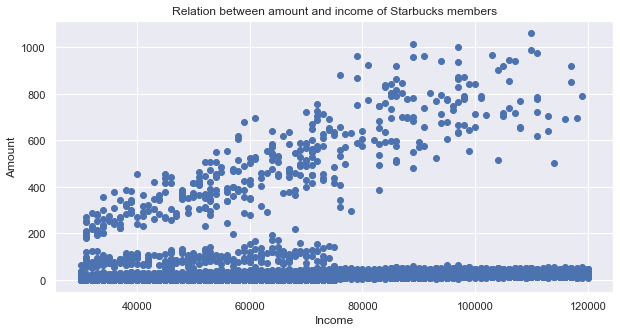

In [79]:
# Show bivariant analysis between amount and income 
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(transaction_profile['income'], transaction_profile['amount'])
ax.set_xlabel('Income')
ax.set_ylabel('Amount')
plt.title('Relation between amount and income of Starbucks members')
plt.show()

In [80]:
# Mean amount by member
transaction_profile['amount'].mean()

13.996324531894118

### Finding Outliers

In [81]:
# Check continous variables in transaction_tr dataset
transaction_tr.describe()

,amount,time_in_days
count,123957.000000,123957.000000
mean,13.996325,15.886592
std,31.749420,8.409545
min,0.050000,0.000000
25%,3.660000,8.750000
50%,10.800000,16.750000
75%,19.130000,23.000000
max,1062.280000,29.750000


As you can see, max value for amount variable is not normal. It is very far that mean + std, so we should analyse the posibility of find some outliers.

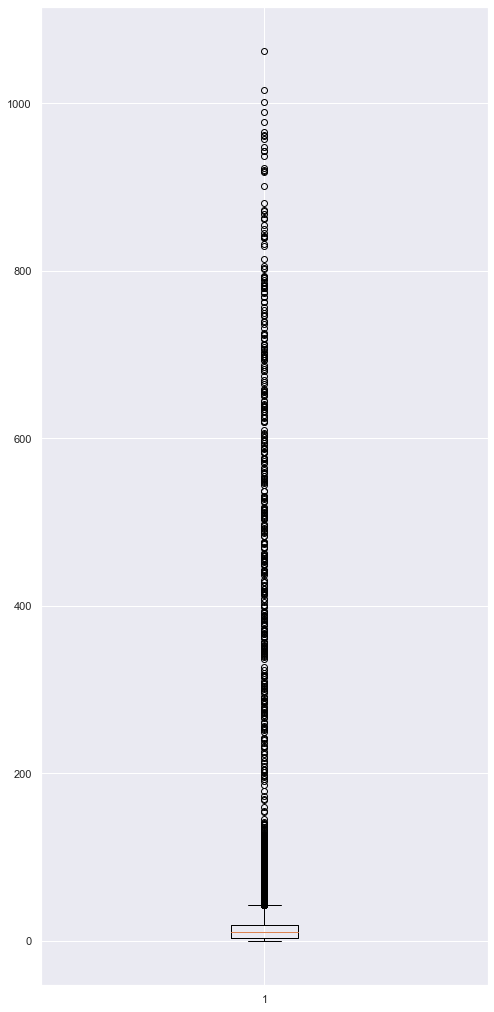

In [82]:
# Show amount boxplot
fig, ax = plt.subplots(figsize=(8, 18))
plt.boxplot(transaction_profile["amount"])
plt.show()

In [83]:
# Get a value for separate outliers than allowed amounts 
max_outlier = transaction_profile['amount'].quantile(0.995)
max_outlier

50.97420000000013

In [84]:
# Impute the median value for outliers (will be outliers amounts greatests than max_outlier)
transaction_profile['amount'] = np.where(transaction_profile['amount'] > max_outlier, 
                                         transaction_profile['amount'].mean(), transaction_profile['amount'])

# Check after outliers are fixed
transaction_profile['amount'].describe()

count    123957.000000
mean         12.310139
std           9.588845
min           0.050000
25%           3.660000
50%          10.800000
75%          18.950000
max          50.950000
Name: amount, dtype: float64

In [85]:
# Calculate correlation between age, income and amount variables
corr = transaction_profile[['age', 'income', 'amount']].corr()

<AxesSubplot:>

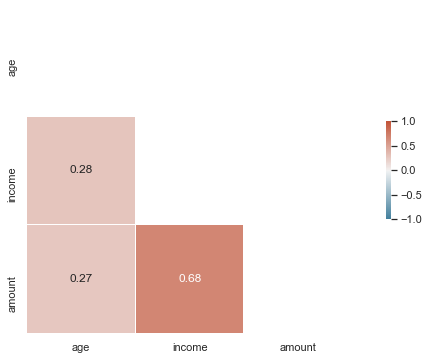

In [86]:
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .3}, vmin=-1, vmax=1, annot=True)

We can see a logical correlation between income and amount variables. So, the greatest incomes spent the greatests amounts generally.

In [87]:
# Shor portfolio dataset
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


## Combine datasets

In [88]:
# Support function. Get the target feature: successful offer
def get_offer_succesful(offer_completed_data_df, offer_viewed_data_df, start_time, end_time):
    
    # get completed offers within end date
    offer_completed_withintime = np.logical_and(
    offer_completed_data_df['time_in_days'] >= start_time, offer_completed_data_df['time_in_days'] <= end_time)
            
    # get viewed offers within end date
    offer_viewed_withintime = np.logical_and(
    offer_viewed_data_df['time_in_days'] >= start_time, offer_viewed_data_df['time_in_days'] <=end_time)

    # offer successful is boolean (1/0): offer_successful is 1 if an offer is viewed and completed within end time, else to 0
    offer_successful = offer_completed_withintime.sum() > 0 and offer_viewed_withintime.sum() > 0
            
    # return the target feature
    return offer_successful

In [89]:
# Support function. Get the customer transaction data
def get_customer_transaction_data(customer_transaction_data_df, start_time, end_time):
    
    # extract transactions occured within time
    transaction_withintime = np.logical_and(
    customer_transaction_data_df['time_in_days'] >= start_time, customer_transaction_data_df['time_in_days'] <= end_time)
        
    transaction_data = customer_transaction_data_df[transaction_withintime]
    
    return transaction_data

In [90]:
# Support function. Get the combined data rows to dictionary
def get_rows(rows, row, offer_row, customer):
                  
    row.update(offer_row.iloc[0,0:].to_dict())
    row.update(customer.iloc[0,:].to_dict())
    rows.append(row)
            
    return rows

In [91]:
# Progressbar library and example of implementation: https://progressbar-2.readthedocs.io/en/latest/

# Main function. Get the combined data between offers, transactions and customers.
def get_data_combined_df(profile, portfolio, offer_profile, transaction_profile):
    '''
    INPUT 
        profile - original profile dataset
        portfolio - original portfolio dataset
        offer_profile - offer_profile dataset
        transaction_profile - transaction_profile dataset
        
    OUTPUT
        Return a combined dataset with the most interesting features to build classification models
    '''
    data_combined = []
    customer_ids = offer_profile['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offer received dataset
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
    
        # get customer
        customer_id = customer_ids[ind]
        
        # get customer from profile dataset
        customer = profile[profile['customer_id']==customer_id]
        
        # get customer_offer_data from offer_profile dataset
        customer_offer_data = offer_profile[offer_profile['customer_id']==customer_id]
        
        # get customer_transaction_data from transaction_profile dataset
        customer_transaction_data = transaction_profile[transaction_profile['customer_id']==customer_id]
        
        # get received, completed and viewed offer data from customer_offer_data dataset
        offer_received_data = customer_offer_data[customer_offer_data['offer received'] == 1]
        offer_completed_data = customer_offer_data[customer_offer_data['offer completed'] == 1]
        offer_viewed_data = customer_offer_data[customer_offer_data['offer viewed'] == 1]
        
        empty_rows = []
        
        # loop for offer receiveds
        for i in range(offer_received_data.shape[0]):
            
            # get offer id from offer_received_data dataset
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # get offer row from portfolio datset
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # set up start and end time from offer_received_data dataset
            start_time = offer_received_data.iloc[i]['time_in_days']
            end_time = start_time + duration_days
           
            # get offer_successful
            offer_successful = get_offer_succesful(offer_completed_data, offer_viewed_data, start_time, end_time)
            
            # get transaction data
            transaction_data = get_customer_transaction_data(customer_transaction_data, start_time, end_time)
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': customer_id,
                'time_in_days': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            rows = get_rows(empty_rows, row, offer_row, customer)
        
        data_combined.extend(rows)
    
    return pd.DataFrame(data_combined)

In [92]:
# get data combined dataset
data_combined_df = get_data_combined_df(profile, portfolio_cl, offer_profile, transaction_profile)

 [Elapsed Time: 0:07:13] |##################################| (Time:  0:07:13) 


In [93]:
# value counts for  target feature
data_combined_df.offer_successful.value_counts()

0    35136
1    31365
Name: offer_successful, dtype: int64

In [94]:
# Show data combined
data_combined_df.head()

,offer_id,customer_id,time_in_days,total_amount,offer_successful,reward,difficulty,duration,channel_email,channel_mobile,...,"age_(10, 20]","age_(20, 30]","age_(30, 40]","age_(40, 50]","age_(50, 60]","age_(60, 70]","age_(70, 80]","age_(80, 90]","age_(90, 100]","age_(100, 110]"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0610b486422d4921ae7d2bf64640c50b,17.0,23.22,0,5,5,7,1,1,...,0,0,0,0,1,0,0,0,0,0
1,3f207df678b143eea3cee63160fa8bed,0610b486422d4921ae7d2bf64640c50b,21.0,23.22,0,0,0,4,1,1,...,0,0,0,0,1,0,0,0,0,0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,5,5,7,1,1,...,0,0,0,0,0,0,1,0,0,0
3,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,7.0,49.39,0,0,0,3,1,1,...,0,0,0,0,0,0,1,0,0,0
4,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,10,10,7,1,1,...,0,0,0,0,0,0,1,0,0,0


In [95]:
# data combined info 
data_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   offer_id          66501 non-null  object 
 1   customer_id       66501 non-null  object 
 2   time_in_days      66501 non-null  float64
 3   total_amount      66501 non-null  float64
 4   offer_successful  66501 non-null  int64  
 5   reward            66501 non-null  int64  
 6   difficulty        66501 non-null  int64  
 7   duration          66501 non-null  int64  
 8   channel_email     66501 non-null  int64  
 9   channel_mobile    66501 non-null  int64  
 10  channel_social    66501 non-null  int64  
 11  channel_web       66501 non-null  int64  
 12  bogo              66501 non-null  int64  
 13  discount          66501 non-null  int64  
 14  informational     66501 non-null  int64  
 15  age               66501 non-null  int64  
 16  income            66501 non-null  float6

In [96]:
# save the final combined data into a csv file in order to apply the best model
data_combined_df.to_csv('data/combined_data.csv', index=False)